# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix




In [4]:
df = pd.read_csv("/content/drive/MyDrive/BA_Projects/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [5]:
df.shape

(50000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [9]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [10]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [11]:
# Booking completion
len(df[df['booking_complete']==1])

7478

In [12]:
# Booking not completion
len(df[df['booking_complete']==0])

42522

In [13]:
df['length_of_stay']

,length_of_stay
0,19
1,20
2,22
3,31
4,22
...,...
49995,6
49996,6
49997,6
49998,6


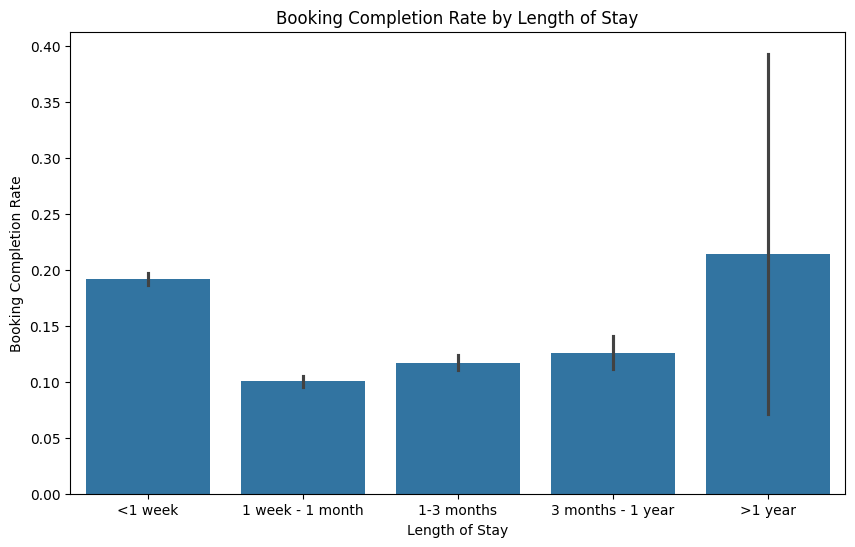

In [14]:
# Create bins for length of stay
bins = [0, 7, 30, 90, 365, 778] # Define bin edges
labels = ['<1 week', '1 week - 1 month', '1-3 months', '3 months - 1 year', '>1 year'] # Define bin labels

df['length_of_stay_binned'] = pd.cut(df['length_of_stay'], bins=bins, labels=labels, right=False)

# Create the bar plot with binned data
plt.figure(figsize=(10, 6))
sns.barplot(x='length_of_stay_binned', y='booking_complete', data=df)
plt.title('Booking Completion Rate by Length of Stay')
plt.xlabel('Length of Stay')
plt.ylabel('Booking Completion Rate')
plt.show()

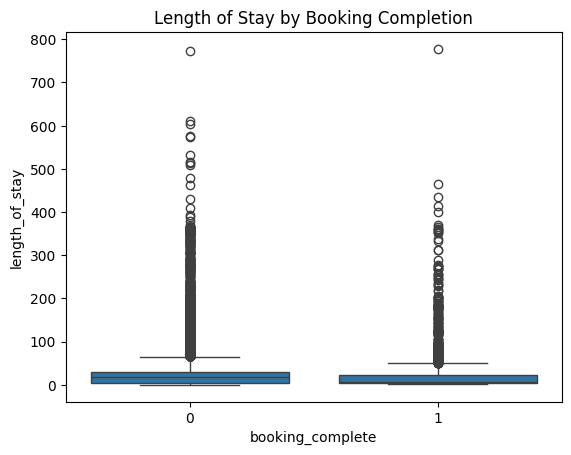

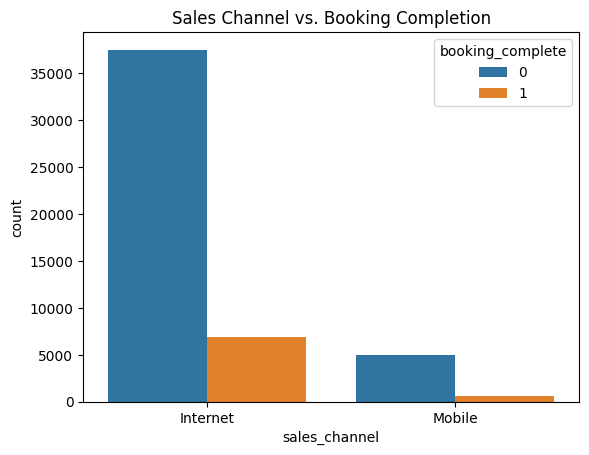

In [15]:
# Distribution of length_of_stay by booking_complete
sns.boxplot(x='booking_complete', y='length_of_stay', data=df)
plt.title('Length of Stay by Booking Completion')
plt.show()

# Sales channel vs. booking completion
sns.countplot(x='sales_channel', hue='booking_complete', data=df)
plt.title('Sales Channel vs. Booking Completion')
plt.show()

In [16]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,length_of_stay_binned
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1 week - 1 month
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1 week - 1 month
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1 week - 1 month
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1-3 months
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1 week - 1 month


In [17]:
df['sales_channel'].unique()

array(['Internet', 'Mobile'], dtype=object)

In [18]:
# converting sales channel to neumeric
df['sales_channel'] = df['sales_channel'].map({'Internet': 1, 'Mobile': 2})

In [19]:
df['sales_channel'].unique()

array([1, 2])

In [20]:
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [21]:
# Get the counts of each trip type
print("Counts of each trip type:")
print(df['trip_type'].value_counts())

Counts of each trip type:
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64


In [22]:
# Get the counts of booking completion for each trip type
print("\nBooking completion counts by trip type:")
print(df.groupby('trip_type')['booking_complete'].value_counts())


Booking completion counts by trip type:
trip_type   booking_complete
CircleTrip  0                     111
            1                       5
OneWay      0                     367
            1                      20
RoundTrip   0                   42044
            1                    7453
Name: count, dtype: int64


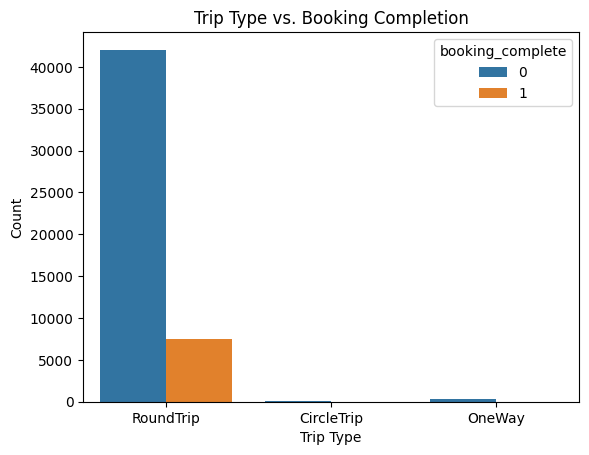

In [23]:
# Visualizing trip type vs. booking completion
sns.countplot(x=df['trip_type'], hue=df['booking_complete']) # Use the original 'trip_type' column before mapping
plt.title('Trip Type vs. Booking Completion')
plt.xlabel('Trip Type')
plt.ylabel('Count')
plt.show()

In [24]:
df['trip_type'] = df['trip_type'].map({'OneWay': 1, 'RoundTrip': 2, 'CircleTrip': 3})

In [25]:
df['trip_type'].unique()

array([2, 3, 1])

In [26]:
df['booking_origin'].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [27]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,length_of_stay_binned
0,2,1,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1 week - 1 month
1,1,1,2,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1 week - 1 month
2,2,1,2,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1 week - 1 month
3,1,1,2,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1-3 months
4,2,1,2,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1 week - 1 month


In [28]:
df['purchase_lead'] = df['purchase_lead'].clip(upper=df['purchase_lead'].quantile(0.99))
df['length_of_stay'] = df['length_of_stay'].clip(upper=df['length_of_stay'].quantile(0.99))

In [29]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,length_of_stay_binned
0,2,1,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1 week - 1 month
1,1,1,2,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1 week - 1 month
2,2,1,2,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1 week - 1 month
3,1,1,2,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1-3 months
4,2,1,2,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1 week - 1 month


In [30]:
df['purchase_lead'].min()

0

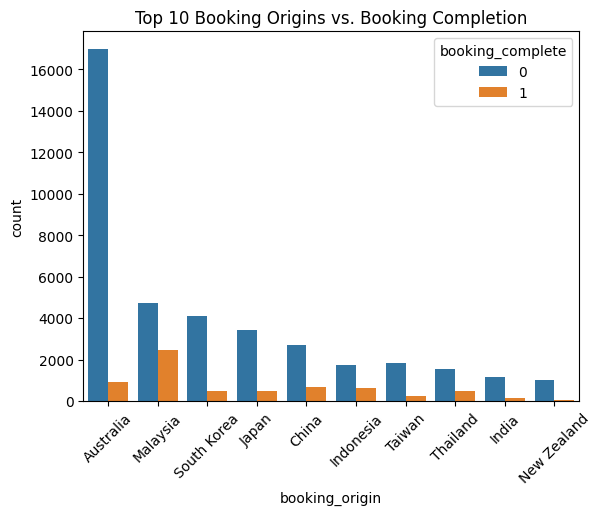

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='booking_origin', hue='booking_complete', data=df, order=df['booking_origin'].value_counts().index[:10])
plt.title('Top 10 Booking Origins vs. Booking Completion')
plt.xticks(rotation=45)
plt.show()

In [32]:
# one hot encoding to route and booking region
df = pd.get_dummies(df, columns=['route', 'booking_origin'], drop_first=True)



In [33]:
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'flight_duration']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [34]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,0.400684,1,2,1.986013,-0.116511,-0.381764,1.096754,1,0,0,...,False,False,False,False,False,False,False,False,False,False
1,-0.579559,1,2,0.306326,-0.080557,-1.120780,1.096754,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0.400684,1,2,1.773252,-0.008649,1.465775,-0.408687,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,-0.579559,1,2,0.127160,0.314937,-0.936026,1.096754,0,0,1,...,False,False,False,False,False,False,False,False,False,False
4,0.400684,1,2,-0.186382,-0.008649,1.096267,-0.408687,1,0,1,...,False,False,False,False,False,False,False,False,False,False


In [40]:
# Define features (X) and target (y)
X = df.drop(['booking_complete', 'length_of_stay_binned'], axis=1)
y = df['booking_complete']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (40000, 912)
X_test shape: (10000, 912)
y_train shape: (40000,)
y_test shape: (10000,)


In [39]:
df['length_of_stay_binned']

,length_of_stay_binned
0,1 week - 1 month
1,1 week - 1 month
2,1 week - 1 month
3,1-3 months
4,1 week - 1 month
...,...
49995,<1 week
49996,<1 week
49997,<1 week
49998,<1 week


In [41]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [43]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.2f}")

Accuracy: 0.86
Precision: 0.55
Recall: 0.13
F1-Score: 0.21
AUC-ROC: 0.79


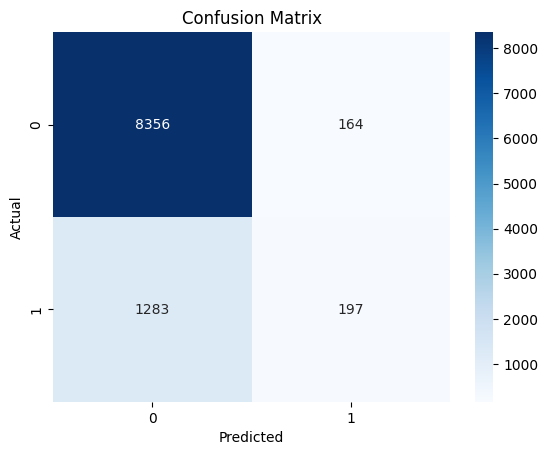

In [44]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### This confusion matrix shows that the model is very accurate at predicting the negative class, but it misses many actual positive cases. Precision for the positive class is moderate, but recall is low, which means the model needs improvement if detecting the positive cases is importan

In [46]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance.head(10))

                      Feature  Importance
3               purchase_lead    0.127749
4              length_of_stay    0.105358
5                 flight_hour    0.103669
6                  flight_day    0.073659
812  booking_origin_Australia    0.047083
10            flight_duration    0.043376
0              num_passengers    0.038581
859   booking_origin_Malaysia    0.036389
9       wants_in_flight_meals    0.019108
7         wants_extra_baggage    0.017354


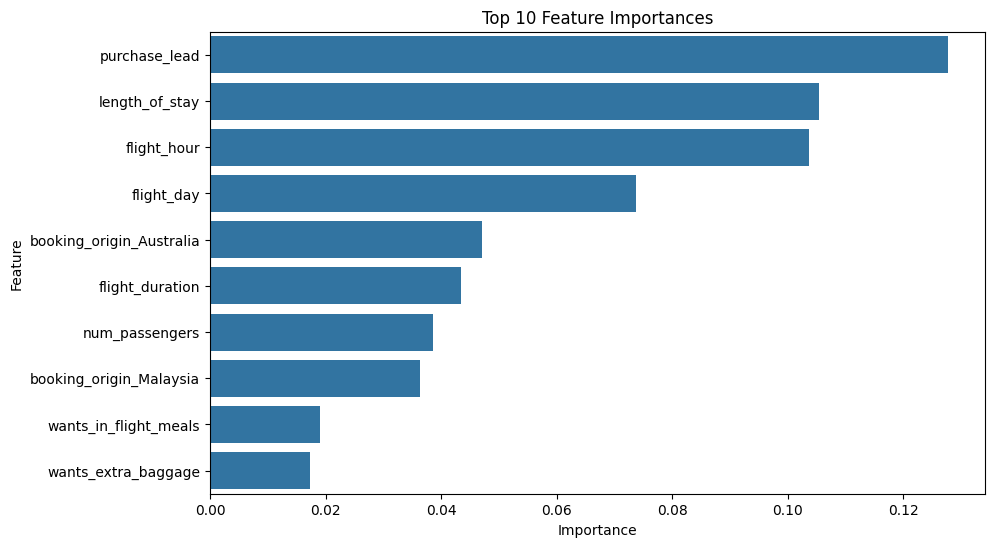

In [47]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

## Since the datasets has only 7478 samples where booking completed, balancing data to see accuracy

In [48]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [49]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (68004, 912)
X_test shape: (10000, 912)
y_train shape: (68004,)
y_test shape: (10000,)


In [50]:
model_1 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [51]:
y_pred = model_1.predict(X_test)
y_pred_proba = model_1.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.2f}")

Accuracy: 0.84
Precision: 0.44
Recall: 0.30
F1-Score: 0.36
AUC-ROC: 0.79


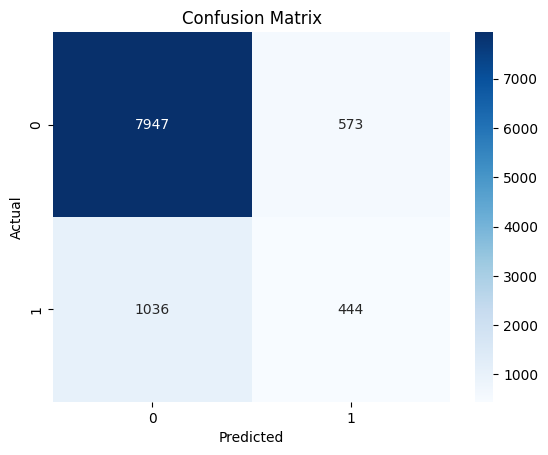

In [52]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

In [55]:
from sklearn.model_selection import RandomizedSearchCV

# Choose RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=50, # Number of parameter settings that are sampled
                                   cv=3, # Number of folds for cross-validation
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1) # Use all available cores

# Perform the hyperparameter tuning
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': None}

Performance of the tuned model:
Accuracy: 0.84
Precision: 0.44
Recall: 0.30
F1-Score: 0.36
AUC-ROC: 0.79


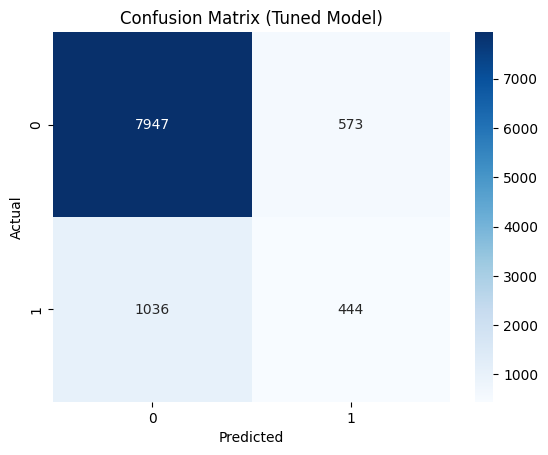

In [56]:
# Get the best hyperparameters from the random search
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new model with the best hyperparameters
tuned_model = RandomForestClassifier(random_state=42, **best_params)
tuned_model.fit(X_train, y_train)

# Evaluate the tuned model on the test set
y_pred_tuned = tuned_model.predict(X_test)
y_pred_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

print("\nPerformance of the tuned model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_tuned):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tuned):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_tuned):.2f}")

# Display the confusion matrix for the tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned Model)')
plt.show()